# Training and testing model

### Importing relevant Libararies, Objects and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys, os
sys.path.append(os.path.abspath(".."))

from sklearn.metrics import confusion_matrix
from torchsummary import summary
import seaborn as sns

from src.train import TrainingAlgorithm
from src.model import model
from src.utils import load_train_val_loaders

### Training Model

Epoch 1/100 - train loss: 0.2324 - val loss: 0.1276 - val acc: 0.9500
Epoch 2/100 - train loss: 0.1258 - val loss: 0.1250 - val acc: 0.9480
Epoch 3/100 - train loss: 0.1174 - val loss: 0.1319 - val acc: 0.9465
Epoch 4/100 - train loss: 0.1138 - val loss: 0.1173 - val acc: 0.9480
Epoch 5/100 - train loss: 0.1125 - val loss: 0.1189 - val acc: 0.9485
Epoch 6/100 - train loss: 0.1114 - val loss: 0.1154 - val acc: 0.9480
Epoch 7/100 - train loss: 0.1097 - val loss: 0.1192 - val acc: 0.9505
Epoch 8/100 - train loss: 0.1052 - val loss: 0.1149 - val acc: 0.9490
Epoch 9/100 - train loss: 0.1043 - val loss: 0.1248 - val acc: 0.9520
Epoch 10/100 - train loss: 0.1087 - val loss: 0.1130 - val acc: 0.9500
Epoch 11/100 - train loss: 0.1028 - val loss: 0.1131 - val acc: 0.9495
Epoch 12/100 - train loss: 0.1034 - val loss: 0.1122 - val acc: 0.9530
Epoch 13/100 - train loss: 0.1007 - val loss: 0.1134 - val acc: 0.9480
Epoch 14/100 - train loss: 0.1017 - val loss: 0.1129 - val acc: 0.9485
Epoch 15/100 - 

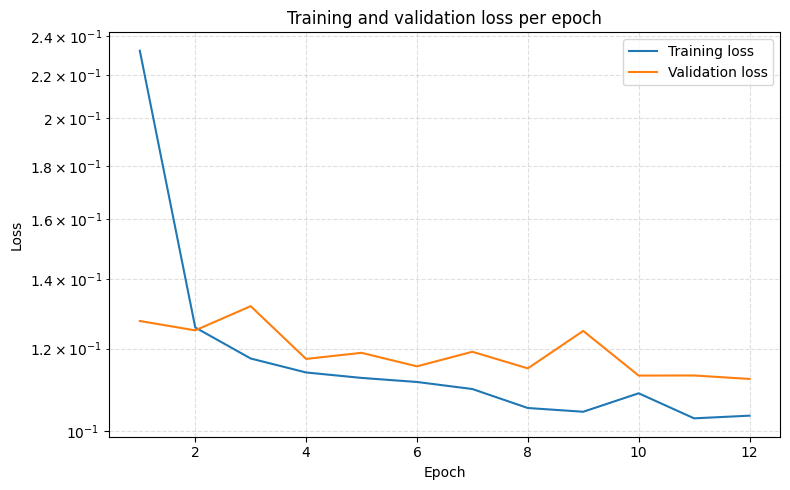

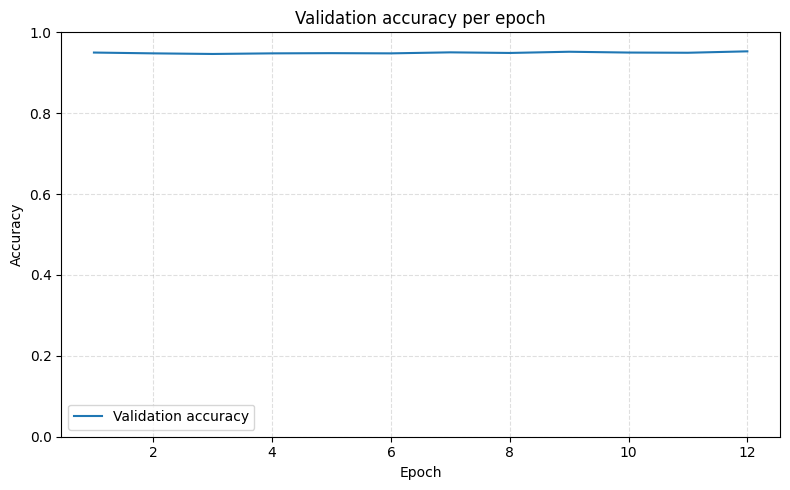

In [2]:
train_loader, val_loader = load_train_val_loaders("data")

m = model(load_weights=False)
num_epochs = 100
train_losses, val_losses, eval_accuracies = TrainingAlgorithm(
    m, train_loader, val_loader, num_epochs=num_epochs, patience=10, device="cpu"
)

epochs = np.arange(1, len(train_losses)+1)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, eval_accuracies, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy per epoch")
plt.ylim(0.0, 1.0)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

### Confusion Matrix

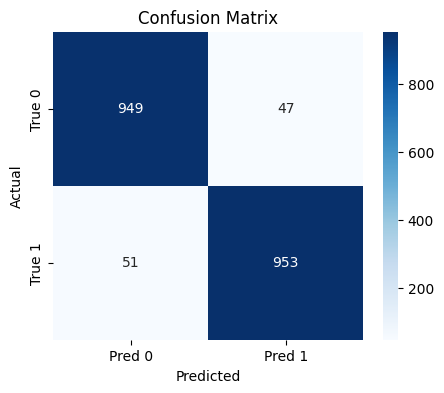

In [3]:
device = "cpu"

#print("eval_accuracies[-1] fra treningsløkken:", eval_accuracies[-1])

m.to(device)
m.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device).float()
        y_val = y_val.to(device).float()

        logits = m(X_val)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()

        all_preds.append(preds.cpu())
        all_targets.append(y_val.cpu())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

#acc_manual = (all_preds == all_targets).float().mean().item()
cm = confusion_matrix(all_targets.numpy(), all_preds.numpy())
#acc_from_cm = (cm[0,0] + cm[1,1]) / cm.sum()

#print("Accuracy beregnet direkte:", acc_manual)
#print("Accuracy fra confusion matrix:", acc_from_cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Loaded pretrained weights from: c:\Users\oskar\ML_course_homeworks\ML4Physics_homework1\src\model_weights.pth


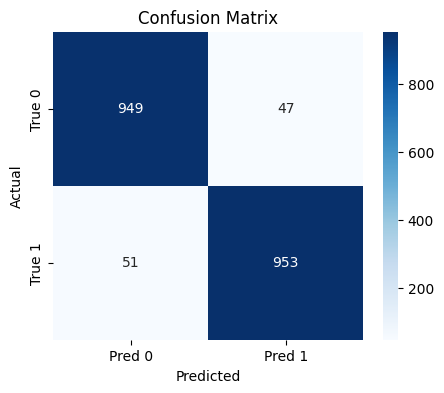

In [4]:
m_confusion = model()
m_confusion.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_val, y_val in val_loader:
        probs = m_confusion.pred(X_val)
        preds = (probs >= 0.5).long()

        all_preds.append(preds.cpu())
        all_targets.append(y_val.view(-1).cpu().long())

all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Testing submission

model.pred() needs to take the same input as the training data and output must be a one-dimensional tensor with the prediction of each input sample.

In [5]:
m_test = model() 
X = torch.load("data\input_data.pt")

y = m_test.pred(X)
print(y)

Loaded pretrained weights from: c:\Users\oskar\ML_course_homeworks\ML4Physics_homework1\src\model_weights.pth
tensor([1.2335e-05, 3.4608e-05, 9.9908e-01,  ..., 1.1629e-04, 6.6583e-02,
        2.0091e-03])


### Summary of parameters

In [6]:
m_sum = model(load_weights=False) 
summary(m_sum, input_size=(1, 12, 12), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 12, 12]             160
         LeakyReLU-2           [-1, 16, 12, 12]               0
            Conv2d-3           [-1, 32, 12, 12]           4,640
         LeakyReLU-4           [-1, 32, 12, 12]               0
         AvgPool2d-5             [-1, 32, 6, 6]               0
            Linear-6                   [-1, 64]          73,792
         LeakyReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                    [-1, 1]              65
Total params: 78,657
Trainable params: 78,657
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 0.30
Estimated Total Size (MB): 0.42
---------------------------------------------